Total memory size (in bytes): 2048
Block/frame size (in bytes): 128
Number of processes: 3

Process ID for task 1: P1
Memory required for P1 (in bytes): 256

Process ID for task 2: P2
Memory required for P2 (in bytes): 400

Process ID for task 3: P3
Memory required for P3 (in bytes): 1024

--- Paging Simulation Using FIFO ---


Allocating memory for Process P1 (needs 2 pages):
  Page 0 → Block 0
  Page 1 → Block 1

Allocating memory for Process P2 (needs 4 pages):
  Page 0 → Block 2
  Page 1 → Block 3
  Page 2 → Block 4
  Page 3 → Block 5

Allocating memory for Process P3 (needs 8 pages):
  Page 0 → Block 6
  Page 1 → Block 7
  Page 2 → Block 8
  Page 3 → Block 9
  Page 4 → Block 10
  Page 5 → Block 11
  Page 6 → Block 12
  Page 7 → Block 13

=== Page Tables ===
Process P1:
  Page 0 → Block 0
  Page 1 → Block 1
Process P2:
  Page 0 → Block 2
  Page 1 → Block 3
  Page 2 → Block 4
  Page 3 → Block 5
Process P3:
  Page 0 → Block 6
  Page 1 → Block 7
  Page 2 → Block 8
  Page 3 → Block 9
 

/var/folders/j7/bbgr2kgx13l46c0q_vpvlgxc0000gn/T/ipykernel_84931/3016030277.py:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap('tab10', len(process_list))


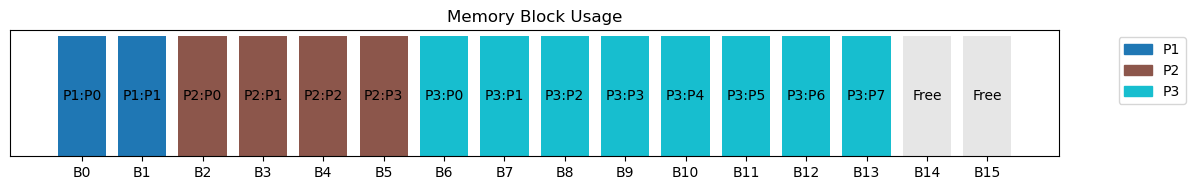

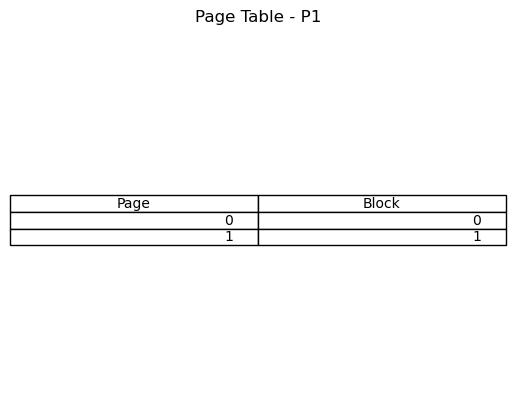

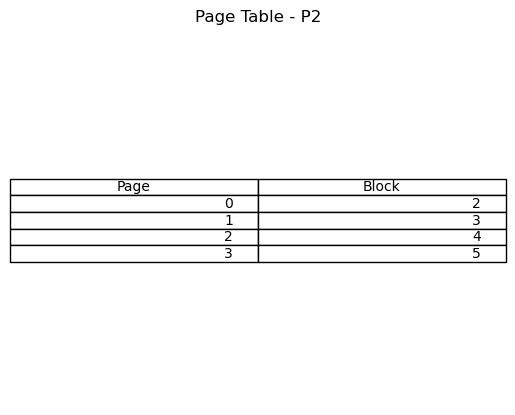

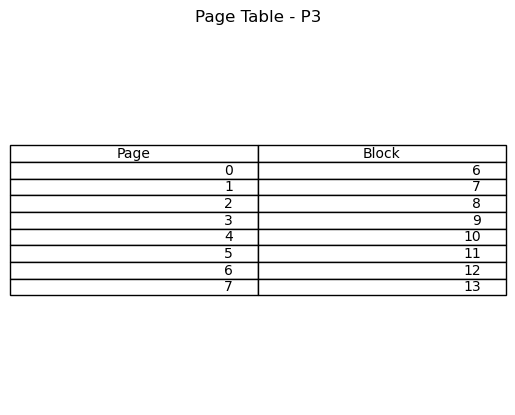

In [2]:
import matplotlib.pyplot as plt
from collections import deque
import matplotlib.patches as mpatches

class MemoryBlock:
    def __init__(self, block_id):
        self.id = block_id
        self.content = None  # Stores (process_name, page_index)

class Task:
    def __init__(self, name, memory_needed, unit_size):
        self.name = name
        self.memory_needed = memory_needed
        self.unit_size = unit_size
        self.total_pages = (memory_needed + unit_size - 1) // unit_size
        self.mapping = {}  # page_index -> block_id

def assign_memory(process_list, memory_capacity, block_size):
    max_blocks = memory_capacity // block_size
    blocks = [MemoryBlock(i) for i in range(max_blocks)]
    queue = deque()

    print("\n--- Paging Simulation Using FIFO ---\n")

    for task in process_list:
        print(f"\nAllocating memory for Process {task.name} (needs {task.total_pages} pages):")
        for pg in range(task.total_pages):
            available_block = next((b for b in blocks if b.content is None), None)

            if available_block:
                available_block.content = (task.name, pg)
                task.mapping[pg] = available_block.id
                queue.append(available_block)
                print(f"  Page {pg} → Block {available_block.id}")
            else:
                replaced = queue.popleft()
                prev_task, prev_pg = replaced.content
                print(f"  Memory full. Replacing {prev_task}'s Page {prev_pg} from Block {replaced.id}")
                for t in process_list:
                    if t.name == prev_task:
                        t.mapping.pop(prev_pg)
                        break
                replaced.content = (task.name, pg)
                task.mapping[pg] = replaced.id
                queue.append(replaced)
                print(f"  Page {pg} → Block {replaced.id}")

    return blocks

def show_summary(process_list, blocks):
    print("\n=== Page Tables ===")
    for task in process_list:
        print(f"Process {task.name}:")
        for pg, blk in task.mapping.items():
            print(f"  Page {pg} → Block {blk}")

    print("\n=== Memory Layout ===")
    for blk in blocks:
        if blk.content:
            pname, pg = blk.content
            print(f"Block {blk.id}: {pname} - Page {pg}")
        else:
            print(f"Block {blk.id}: Free")

def plot_allocation(process_list, blocks):
    palette = plt.cm.get_cmap('tab10', len(process_list))
    task_colors = {task.name: palette(i) for i, task in enumerate(process_list)}

    tags = []
    colors = []
    for blk in blocks:
        if blk.content:
            pname, pg = blk.content
            tags.append(f"{pname}:P{pg}")
            colors.append(task_colors[pname])
        else:
            tags.append("Free")
            colors.append((0.9, 0.9, 0.9))  # light grey

    plt.figure(figsize=(12, 2))
    visual_blocks = plt.bar(range(len(blocks)), [1]*len(blocks), color=colors)
    plt.xticks(range(len(blocks)), [f"B{i}" for i in range(len(blocks))])
    plt.yticks([])
    for bar, label in zip(visual_blocks, tags):
        plt.text(bar.get_x() + bar.get_width()/2, 0.5, label, ha='center', va='center')
    plt.title("Memory Block Usage")
    legend_entries = [mpatches.Patch(color=clr, label=name) for name, clr in task_colors.items()]
    plt.legend(handles=legend_entries, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    for task in process_list:
        fig, ax = plt.subplots()
        pages = list(task.mapping.keys())
        assigned_blocks = [task.mapping[p] for p in pages]
        ax.axis('tight')
        ax.axis('off')
        table_entries = [[p, b] for p, b in zip(pages, assigned_blocks)]
        table = ax.table(cellText=table_entries, colLabels=["Page", "Block"], loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        ax.set_title(f"Page Table - {task.name}", pad=10)
        plt.show()

# Execution starts here
if __name__ == "__main__":
    memory_limit = int(input("Total memory size (in bytes): "))
    block_unit = int(input("Block/frame size (in bytes): "))

    task_count = int(input("Number of processes: "))
    all_tasks = []

    for i in range(task_count):
        identifier = input(f"\nProcess ID for task {i + 1}: ")
        required_mem = int(input(f"Memory required for {identifier} (in bytes): "))
        all_tasks.append(Task(identifier, required_mem, block_unit))

    final_blocks = assign_memory(all_tasks, memory_limit, block_unit)
    show_summary(all_tasks, final_blocks)
    plot_allocation(all_tasks, final_blocks)
